In [2]:
# Imports for pytorch
import numpy as np
import torch
import torchvision
from torch import nn
import matplotlib
from matplotlib import pyplot as plt
# import tqdm
from tqdm import tqdm
import pdb
import random

In [3]:
np.random.seed(6312)
random.seed(7272)

# Part 1: Naive CNN
Last Spring, I took CS 189, where I build a CNN in a conventional way: Look at previous examples and blindly experiment off of them. I will start with that network, calculate the MEC, and make a better one.

Forgive me if some of the decisions here look silly, I did not know much about CNNs or deep learning back in the day.

In [4]:
from torchvision.transforms.autoaugment import F
### YOUR CODE HERE ###

def make_epoch_plot(epochs, train, valid, plt_type="Loss", problem_name="MLP on FashionMNIST"):
    plt.plot(epochs, train, label=f"Training {plt_type}")
    plt.plot(epochs, valid, label=f"Validation {plt_type}")
    plt.title(f'Training and Validation {plt_type} vs. Epochs for {problem_name}')
    plt.xlabel('Epoch Number')
    plt.ylabel(plt_type)
    plt.legend()
    plt.show()

In [5]:
# Creating the datasets, feel free to change this as long as you do the same to the test data.
# You can also modify this to split the data into training and validation.
# See https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split

transform = torchvision.transforms.ToTensor()

training_data = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transform,
)
print(len(training_data))
validation_data = torchvision.datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

print(len(validation_data))
# If you make a train-test partition it is up to you.

Files already downloaded and verified
50000
Files already downloaded and verified
10000


In [6]:
print(training_data[1][0].shape)
print(len(training_data))

torch.Size([3, 32, 32])
50000


## The Original CNN

In [7]:
class MikeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 128, 3)
    self.conv2 = nn.Conv2d(128, 256, 3)
    self.dropout1 = nn.Dropout(0.4)
    self.conv3 = nn.Conv2d(256, 512, 3)
    self.dropout2 = nn.Dropout(0.4)
    self.conv4 = nn.Conv2d(512, 1024, 3)

    # an affine operation: y = Wx + b
    self.fc1 = nn.Linear(1024 * 3 * 3, 512)
    self.dropout3 = nn.Dropout(0.4)
    self.fc2 = nn.Linear(512, 128)
    self.fc3 = nn.Linear(128, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2)
    # If the size is a square, you can specify with a single number
    x = F.relu(self.conv2(x))
    x = self.dropout1(x)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2)
    x = F.relu(self.conv4(x))
    x = self.dropout2(x)
    #x = F.relu(self.conv5(x))
    x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
    x = F.relu(self.fc1(x))
    x = self.dropout3(x)
    x = F.relu(self.fc2(x))
    #x = F.softmax(self.fc3(x), dim=1)
    x = self.fc3(x)
    return x

In [8]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)
criterion = torch.nn.CrossEntropyLoss()


def predict(model, dataloader, test=False):
  with torch.no_grad():
      losses = []
      model.eval() # Put model in eval mode
      num_correct = 0
      # i = 0
      # pred_vec = torch.zeros([len(dataloader.dataset), 1])
      pred_vec = []
      for x, y in dataloader:
          x, y = x.float().to(device), y.float().to(device)
          pred = model(x)
          pred_nums = torch.argmax(pred, dim=1)
          correct_in_batch = torch.sum(torch.round(pred_nums) == y).item()
          # if correct_in_batch < 5:
          #     #print(f"MAJOR ISSUE: correct_in_batch: {correct_in_batch}")
          #     print(f"pred: {pred}")
          #     print(f"pred_nums: {pred_nums}")
          #     print(f"correct_in_batch: {correct_in_batch};  len(x): {x.shape[0]}")
          #     print(f"y: {y}")
          #     print(f"Thing: {torch.round(pred_nums) == y}")
          num_correct += correct_in_batch
          loss = criterion(pred, y.long())
          losses.append(loss.item())
          if test:
            pred_vec += torch.flatten(pred_nums).tolist()
      acc = num_correct / len(dataloader.dataset)

      #print(f"Accuracy: {acc}; num_correct: {num_correct}; length: {len(dataloader.dataset)}")
      mean_loss = np.mean(losses)
      model.train() # Put model back in train mode
      return acc, mean_loss


Using device cuda


## Training the Original CNN

  1%|          | 17/3334 [00:00<00:19, 169.25batch/s]

Using device cuda


100%|██████████| 3334/3334 [00:23<00:00, 140.26batch/s]


Finished Epoch 1!
Predicting for training...
Training loss: 1.6288666317723222 ... Training accuracy: 0.3949
Predicting for validation...


  1%|          | 17/3334 [00:00<00:19, 166.39batch/s]

Validation loss: 1.6318317746472681 ... Validation accuracy: 0.3879


100%|██████████| 3334/3334 [00:23<00:00, 139.04batch/s]


Finished Epoch 2!
Predicting for training...
Training loss: 1.2412444207756979 ... Training accuracy: 0.5439
Predicting for validation...


  1%|          | 18/3334 [00:00<00:19, 171.74batch/s]

Validation loss: 1.2791180628529195 ... Validation accuracy: 0.532


100%|██████████| 3334/3334 [00:23<00:00, 140.35batch/s]


Finished Epoch 3!
Predicting for training...
Training loss: 1.0354165882944846 ... Training accuracy: 0.63544
Predicting for validation...


  1%|          | 18/3334 [00:00<00:18, 177.07batch/s]

Validation loss: 1.1040666367875405 ... Validation accuracy: 0.6154


100%|██████████| 3334/3334 [00:23<00:00, 139.78batch/s]


Finished Epoch 4!
Predicting for training...
Training loss: 0.8451953732733177 ... Training accuracy: 0.7059
Predicting for validation...


  1%|          | 18/3334 [00:00<00:19, 170.92batch/s]

Validation loss: 0.9539376925760839 ... Validation accuracy: 0.6732


100%|██████████| 3334/3334 [00:23<00:00, 139.90batch/s]


Finished Epoch 5!
Predicting for training...
Training loss: 0.661508354279601 ... Training accuracy: 0.77278
Predicting for validation...


  1%|          | 17/3334 [00:00<00:19, 168.81batch/s]

Validation loss: 0.8228750327403757 ... Validation accuracy: 0.7063


100%|██████████| 3334/3334 [00:23<00:00, 140.60batch/s]


Finished Epoch 6!
Predicting for training...
Training loss: 0.5523708165295301 ... Training accuracy: 0.80974
Predicting for validation...


  1%|          | 18/3334 [00:00<00:19, 173.59batch/s]

Validation loss: 0.7893418882941378 ... Validation accuracy: 0.7322


100%|██████████| 3334/3334 [00:21<00:00, 151.55batch/s]


Finished Epoch 7!
Predicting for training...
Training loss: 0.4380124700023839 ... Training accuracy: 0.8578
Predicting for validation...


  1%|          | 17/3334 [00:00<00:19, 166.92batch/s]

Validation loss: 0.724162449286706 ... Validation accuracy: 0.7546


100%|██████████| 3334/3334 [00:21<00:00, 153.40batch/s]


Finished Epoch 8!
Predicting for training...
Training loss: 0.38490176809382926 ... Training accuracy: 0.87346
Predicting for validation...


  1%|          | 17/3334 [00:00<00:20, 162.71batch/s]

Validation loss: 0.723650725494171 ... Validation accuracy: 0.7603


100%|██████████| 3334/3334 [00:23<00:00, 139.08batch/s]


Finished Epoch 9!
Predicting for training...
Training loss: 0.30332527367591444 ... Training accuracy: 0.899
Predicting for validation...


  1%|          | 17/3334 [00:00<00:19, 169.00batch/s]

Validation loss: 0.6953267900348603 ... Validation accuracy: 0.7661


100%|██████████| 3334/3334 [00:24<00:00, 138.76batch/s]


Finished Epoch 10!
Predicting for training...
Training loss: 0.24770579158342998 ... Training accuracy: 0.91804
Predicting for validation...


  1%|          | 18/3334 [00:00<00:19, 170.94batch/s]

Validation loss: 0.6951743184995168 ... Validation accuracy: 0.776


100%|██████████| 3334/3334 [00:23<00:00, 140.03batch/s]


Finished Epoch 11!
Predicting for training...
Training loss: 0.2070528545768023 ... Training accuracy: 0.93116
Predicting for validation...


  1%|          | 18/3334 [00:00<00:19, 169.63batch/s]

Validation loss: 0.6941697684045451 ... Validation accuracy: 0.7746


100%|██████████| 3334/3334 [00:23<00:00, 139.53batch/s]


Finished Epoch 12!
Predicting for training...
Training loss: 0.18539096143802858 ... Training accuracy: 0.94342
Predicting for validation...


  1%|          | 17/3334 [00:00<00:19, 169.93batch/s]

Validation loss: 0.7237268639435207 ... Validation accuracy: 0.7746


100%|██████████| 3334/3334 [00:23<00:00, 139.10batch/s]


Finished Epoch 13!
Predicting for training...
Training loss: 0.15368615874803296 ... Training accuracy: 0.95148
Predicting for validation...


  1%|          | 17/3334 [00:00<00:20, 165.16batch/s]

Validation loss: 0.7452579781139407 ... Validation accuracy: 0.7751


100%|██████████| 3334/3334 [00:23<00:00, 139.65batch/s]


Finished Epoch 14!
Predicting for training...
Training loss: 0.15007641883097683 ... Training accuracy: 0.9559
Predicting for validation...


  1%|          | 17/3334 [00:00<00:20, 164.93batch/s]

Validation loss: 0.7736836230854268 ... Validation accuracy: 0.772


100%|██████████| 3334/3334 [00:24<00:00, 137.93batch/s]


Finished Epoch 15!
Predicting for training...
Training loss: 0.08793143514668358 ... Training accuracy: 0.97608
Predicting for validation...
Validation loss: 0.7400835531315525 ... Validation accuracy: 0.7854


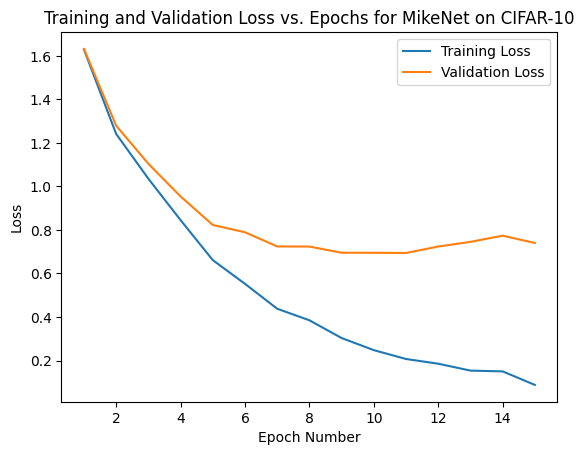

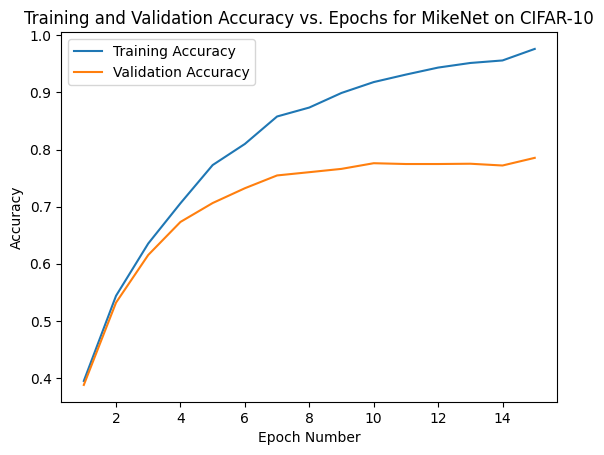

In [51]:
### YOUR CODE HERE ###
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)

epochs = 15
batch_size = 15
learning_rate = 0.005
#learning_rate = 0.01

num_features = np.prod(list(training_data[0][0].shape))
#print(f"Num features: {num_features}; Model params: {model.parameters()}")
model = MikeNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)

model.train() # Put model in training mode
train_accs = []
valid_accs = []
mean_train_losses = []
mean_valid_losses = []
epoch_list = []
for epoch in range(epochs):
    for x, y in tqdm(train_dataloader, unit="batch"):
        #x = torch.reshape(x, (x.shape[0], -1))
        x, y = x.float().to(device), y.float().to(device)
        optimizer.zero_grad() # Remove the gradients from the previous step
        pred = model(x)
        loss = criterion(pred, y.long())
        loss.backward()
        optimizer.step()
        #train_losses.append(loss.item())

    print(f"Finished Epoch {epoch + 1}!")
    epoch_list.append(epoch + 1)
    print("Predicting for training...")
    train_acc, train_loss = predict(model, train_dataloader)
    print(f"Training loss: {train_loss} ... Training accuracy: {train_acc}")
    print("Predicting for validation...")
    valid_acc, valid_loss = predict(model, valid_dataloader)
    print(f"Validation loss: {valid_loss} ... Validation accuracy: {valid_acc}")

    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    mean_train_losses.append(train_loss)
    mean_valid_losses.append(valid_loss)


    # print(f"Finished Epoch{epoch + 1}\nTraining loss: {np.mean(train_losses)}")

# We can run predictions on the data to determine the final accuracy.
make_epoch_plot(epoch_list, mean_train_losses, mean_valid_losses, plt_type="Loss", problem_name="MikeNet on CIFAR-10")
make_epoch_plot(epoch_list, train_accs, valid_accs, plt_type="Accuracy", problem_name="MikeNet on CIFAR-10")




## Original Model Analysis

### Performance: The model acheives 90% train accuracy and 75.6% validation accuracy

### Let's look at the architecture

```
self.conv1 = nn.Conv2d(3, 128, 3) 
self.conv2 = nn.Conv2d(128, 256, 3) # input: [b, 30, 30, 128]. output: [b, 28, 28, 256]
self.dropout1 = nn.Dropout(0.4)
self.conv3 = nn.Conv2d(256, 512, 3) # input: [b, 28, 28, 256]. output: [b, 26, 26, 512]
self.dropout2 = nn.Dropout(0.4)
self.conv4 = nn.Conv2d(512, 1024, 3) # input: [b, 26, 26, 512]. output: [b, 24, 24, 1024]

self.fc1 = nn.Linear(1024 * 3 * 3, 512)
self.dropout3 = nn.Dropout(0.4)
self.fc2 = nn.Linear(512, 128)
self.fc3 = nn.Linear(128, 10)


def forward(self, x):
    x = F.relu(self.conv1(x)) # input: [b, 32, 32, 3]. output: [b, 30, 30, 128]
    x = F.max_pool2d(x, 2) # input: [b, 32, 32, 3]. output: [b, 15, 15, 128]
    x = F.relu(self.conv2(x)) # input: [b, 15, 15, 128]. output: [b, 13, 13, 256]
    x = self.dropout1(x)
    x = F.relu(self.conv3(x)) # input: [b, 13, 13, 256]. output: [b, 11, 11, 512]
    x = F.max_pool2d(x, 2) # input: [b, 11, 11, 512]. output: [b, 5, 5, 512]
    x = F.relu(self.conv4(x)) # input: [b, 5, 5, 512]. output: [b, 3, 3, 512]
    x = self.dropout2(x)
    x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
    x = F.relu(self.fc1(x))
    x = self.dropout3(x)
    x = F.relu(self.fc2(x))
    #x = F.softmax(self.fc3(x), dim=1)
    x = self.fc3(x)
    return x

```

### Compression
In terms of compression from the convolution, I have discovered something quite silly about this network... It seems this network didn't actually compress anything at all.
That is, the compression ratio is: b * 32 * 32 * 3 / (b * 3 * 3 * 1024) = 1/3
(Again, in my defense, I really did not know what I was doing, but at least these methods formalize that I did not know wtf I was doing.)
By the data impression inequality, this part of the model is too big jusy by the fact that I am trying to "create" information

### MEC: 

(1024 * 3 * 3 + 1) * 512 + 512 + 128 = 4719744 bits MEC 
Wow that's way too much!




In [21]:
def conv_output_dim(input_dim, pad, kernel, stride):
    return int((input_dim + 2 * pad - kernel) / stride + 1)

def pool_output_dim(input_dim, pad, kernel, stride):
    return int((input_dim + 2 * pad - (kernel - 1) - 1) / stride + 1)

In [45]:
print(conv_output_dim(14, 0, 3, 1))
print(pool_output_dim(12, 0, 2, 2))

12
6


# Adjustments based off of MEC

### Calculating necessary MEC: 
There are 50000 data points and 10 classes. log_2(10) = 4; 4 * 50000 = 200000 bits of necessary MEC. 
Let's make the MLP of the following architecture:
(1024, 256)
(256, 64)
(64, 10)
This would have (1024 + 1) * 256 + 256 + 64 = 262720 bits of MEC. (Still 62720 over necessary).

Making the input to the MLP 1024 features would also make the compression ratio of all convolutional layers 32 * 32 * 3 / 1024 = 3


### New CNN

In [49]:
class MikeNetMEC(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 64, 3) # 32 > 30
    self.conv2 = nn.Conv2d(64, 256, 3) # 30 > 28
    self.max1 = nn.MaxPool2d(2) # 28 > 14
    self.dropout1 = nn.Dropout(0.4)
    self.conv3 = nn.Conv2d(256, 512, 3) # 14 > 12
    self.max2 = nn.MaxPool2d(2) # 12 > 6

    self.dropout2 = nn.Dropout(0.4)
    self.conv4 = nn.Conv2d(512, 1024, 4) # 6 > 3
    self.max3 = nn.MaxPool2d(2) # 3 > 1


    # an affine operation: y = Wx + b
    self.fc1 = nn.Linear(1024, 256)
    self.dropout3 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(256, 64)
    self.fc3 = nn.Linear(64, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.max1(x)
    x = self.dropout1(x)  

    x = F.relu(self.conv3(x))
    x = self.max2(x)
    # print(x.shape)

    x = F.relu(self.conv4(x))
    x = self.max3(x)
    x = self.dropout2(x)

    x = torch.flatten(x, 1) 
    x = F.relu(self.fc1(x))
    x = self.dropout3(x)
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

  0%|          | 0/3334 [00:00<?, ?batch/s]

  0%|          | 14/3334 [00:00<00:24, 132.92batch/s]

Using device cuda


100%|██████████| 3334/3334 [00:24<00:00, 135.29batch/s]


Finished Epoch 1!
Training loss: 1.6972169472775063 ... Training accuracy: 0.3736


  0%|          | 15/3334 [00:00<00:23, 141.29batch/s]

Validation loss: 1.6962496260295565 ... Validation accuracy: 0.3737


100%|██████████| 3334/3334 [00:24<00:00, 136.43batch/s]


Finished Epoch 2!
Training loss: 1.2037883737645754 ... Training accuracy: 0.56766


  0%|          | 15/3334 [00:00<00:22, 148.42batch/s]

Validation loss: 1.23877716841905 ... Validation accuracy: 0.5566


100%|██████████| 3334/3334 [00:23<00:00, 143.28batch/s]


Finished Epoch 3!
Training loss: 0.9786791130140575 ... Training accuracy: 0.65324


  0%|          | 15/3334 [00:00<00:23, 142.99batch/s]

Validation loss: 1.0574986276061817 ... Validation accuracy: 0.6221


100%|██████████| 3334/3334 [00:22<00:00, 147.59batch/s]


Finished Epoch 4!
Training loss: 0.7544561596011858 ... Training accuracy: 0.74196


  0%|          | 15/3334 [00:00<00:23, 142.56batch/s]

Validation loss: 0.8875601410061523 ... Validation accuracy: 0.6962


100%|██████████| 3334/3334 [00:22<00:00, 151.18batch/s]


Finished Epoch 5!
Training loss: 0.6508486580950598 ... Training accuracy: 0.7879


  0%|          | 14/3334 [00:00<00:23, 139.72batch/s]

Validation loss: 0.8287344885462228 ... Validation accuracy: 0.718


100%|██████████| 3334/3334 [00:20<00:00, 165.71batch/s]


Finished Epoch 6!
Training loss: 0.5404138358775805 ... Training accuracy: 0.82502


  0%|          | 15/3334 [00:00<00:22, 147.37batch/s]

Validation loss: 0.760163899282108 ... Validation accuracy: 0.739


100%|██████████| 3334/3334 [00:23<00:00, 144.79batch/s]


Finished Epoch 7!
Training loss: 0.42933697651302966 ... Training accuracy: 0.85824


  0%|          | 15/3334 [00:00<00:23, 141.21batch/s]

Validation loss: 0.7454171246182972 ... Validation accuracy: 0.757


100%|██████████| 3334/3334 [00:24<00:00, 134.95batch/s]


Finished Epoch 8!
Training loss: 0.4170776746304506 ... Training accuracy: 0.86688


  0%|          | 14/3334 [00:00<00:24, 137.74batch/s]

Validation loss: 0.7919279990614444 ... Validation accuracy: 0.7408


100%|██████████| 3334/3334 [00:24<00:00, 135.63batch/s]


Finished Epoch 9!
Training loss: 0.3690216262496887 ... Training accuracy: 0.87766


  0%|          | 14/3334 [00:00<00:23, 138.61batch/s]

Validation loss: 0.7693834666615126 ... Validation accuracy: 0.7382


100%|██████████| 3334/3334 [00:24<00:00, 135.51batch/s]


Finished Epoch 10!
Training loss: 0.2795670036333778 ... Training accuracy: 0.91004


  0%|          | 15/3334 [00:00<00:23, 141.56batch/s]

Validation loss: 0.7556407358357753 ... Validation accuracy: 0.753


100%|██████████| 3334/3334 [00:23<00:00, 142.24batch/s]


Finished Epoch 11!
Training loss: 0.18717799434353427 ... Training accuracy: 0.94064


  0%|          | 15/3334 [00:00<00:23, 141.37batch/s]

Validation loss: 0.7344786720029239 ... Validation accuracy: 0.7706


100%|██████████| 3334/3334 [00:23<00:00, 139.87batch/s]


Finished Epoch 12!
Training loss: 0.16804470733756754 ... Training accuracy: 0.94704


  0%|          | 15/3334 [00:00<00:23, 142.24batch/s]

Validation loss: 0.7314174479261778 ... Validation accuracy: 0.7705


100%|██████████| 3334/3334 [00:23<00:00, 139.35batch/s]


Finished Epoch 13!
Training loss: 0.12256982430006166 ... Training accuracy: 0.9651


  0%|          | 15/3334 [00:00<00:22, 146.90batch/s]

Validation loss: 0.7308960540898737 ... Validation accuracy: 0.7804


100%|██████████| 3334/3334 [00:24<00:00, 138.32batch/s]


Finished Epoch 14!
Training loss: 0.10946803908780732 ... Training accuracy: 0.9686


  0%|          | 15/3334 [00:00<00:22, 148.28batch/s]

Validation loss: 0.7335392287771764 ... Validation accuracy: 0.7803


100%|██████████| 3334/3334 [00:23<00:00, 140.93batch/s]


Finished Epoch 15!
Training loss: 0.08987029381213686 ... Training accuracy: 0.97504
Validation loss: 0.7581251743438093 ... Validation accuracy: 0.7779


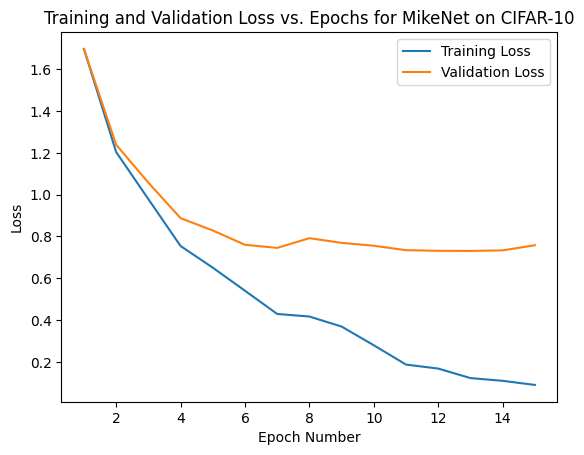

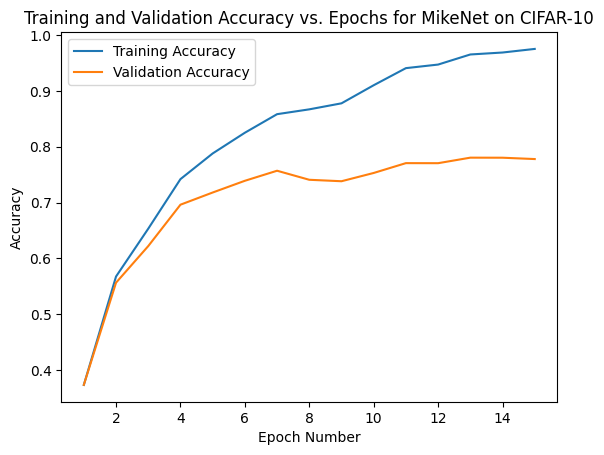

In [50]:
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)

epochs = 15
batch_size = 15
learning_rate = 0.005
# learning_rate = 0.01

num_features = np.prod(list(training_data[0][0].shape))
#print(f"Num features: {num_features}; Model params: {model.parameters()}")
model = MikeNetMEC().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)

model.train() # Put model in training mode
train_accs = []
valid_accs = []
mean_train_losses = []
mean_valid_losses = []
epoch_list = []
for epoch in range(epochs):
    for x, y in tqdm(train_dataloader, unit="batch"):
        #x = torch.reshape(x, (x.shape[0], -1))
        x, y = x.float().to(device), y.float().to(device)
        optimizer.zero_grad() # Remove the gradients from the previous step
        pred = model(x)
        loss = criterion(pred, y.long())
        loss.backward()
        optimizer.step()
        #train_losses.append(loss.item())

    print(f"Finished Epoch {epoch + 1}!")
    epoch_list.append(epoch + 1)
    # print("Predicting for training...")
    train_acc, train_loss = predict(model, train_dataloader)
    print(f"Training loss: {train_loss} ... Training accuracy: {train_acc}")
    # print("Predicting for validation...")
    valid_acc, valid_loss = predict(model, valid_dataloader)
    print(f"Validation loss: {valid_loss} ... Validation accuracy: {valid_acc}")

    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    mean_train_losses.append(train_loss)
    mean_valid_losses.append(valid_loss)


    # print(f"Finished Epoch{epoch + 1}\nTraining loss: {np.mean(train_losses)}")

# We can run predictions on the data to determine the final accuracy.
make_epoch_plot(epoch_list, mean_train_losses, mean_valid_losses, plt_type="Loss", problem_name="MikeNet on CIFAR-10")
make_epoch_plot(epoch_list, train_accs, valid_accs, plt_type="Accuracy", problem_name="MikeNet on CIFAR-10")

